<a href="https://colab.research.google.com/github/Serge3leo/temp-cola/blob/main/ruSO/%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8/%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Serge3leo/temp-cola.git/HEAD?urlpath=%2Fdoc%2Ftree%2FruSO%2F%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8%2F%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8.ipynb)

# К вопросу о загрузке данных для записок
Заметка к моему вопросу на ruSO: ...

## Импорт и установки

In [1]:
# import time
# osx_start = time.time()
# try:
#     %matplotlib osx
# except Exception as exc:
#     print(f"{time.time() - osx_start, exc=}")
#     time.sleep(0.05)
#     %matplotlib osx
# %matplotlib osx
# %matplotlib ipympl
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import matplotlib.pyplot as plt
import PIL.Image

## Загрузка данных записки Jupyter Notebook из GitHub

При открытии заметки (.ipynb) локально, на `github.dev` (`Codespaces`)
или в `binder`, все файлы каталога, содержащего заметку, обычно,
доступны. Но при открытии в `Colab` это не так.

Для `Colab` требуется нижеследующий код:

In [2]:
ipnb_depends = ["текстовый-файл.txt", "картинка.jpg"]

if 'google.colab' in str(get_ipython().config):
    ipnb_repo, ipnb_path = os.environ['COLAB_NOTEBOOK_ID'].split("/blob/")
    ipnb_dir = os.path.dirname(ipnb_path)
    for d in ipnb_depends:
        if not os.path.exists(d):
            !wget '{ipnb_repo + "/raw/" + ipnb_dir + "/" + d}'

## Проверим, всё ли более менее?

Строго говоря, поскольку `wget` не `git`, могут быть различные
интерпретации, но в простых случаях проблем незаметно.

### Проверка за UTF-8 кодирование

In [3]:
with open("текстовый-файл.txt", encoding='utf-8') as fi:
    etext = fi.read()
    esegments = etext.split("'")
    assert ('Ё', 2) == (esegments[1], len(esegments[1]))
    print(etext)
print("Хорь")

Привет! Какая длина у 'Ё'?

Хорь


### Проверка за картинку

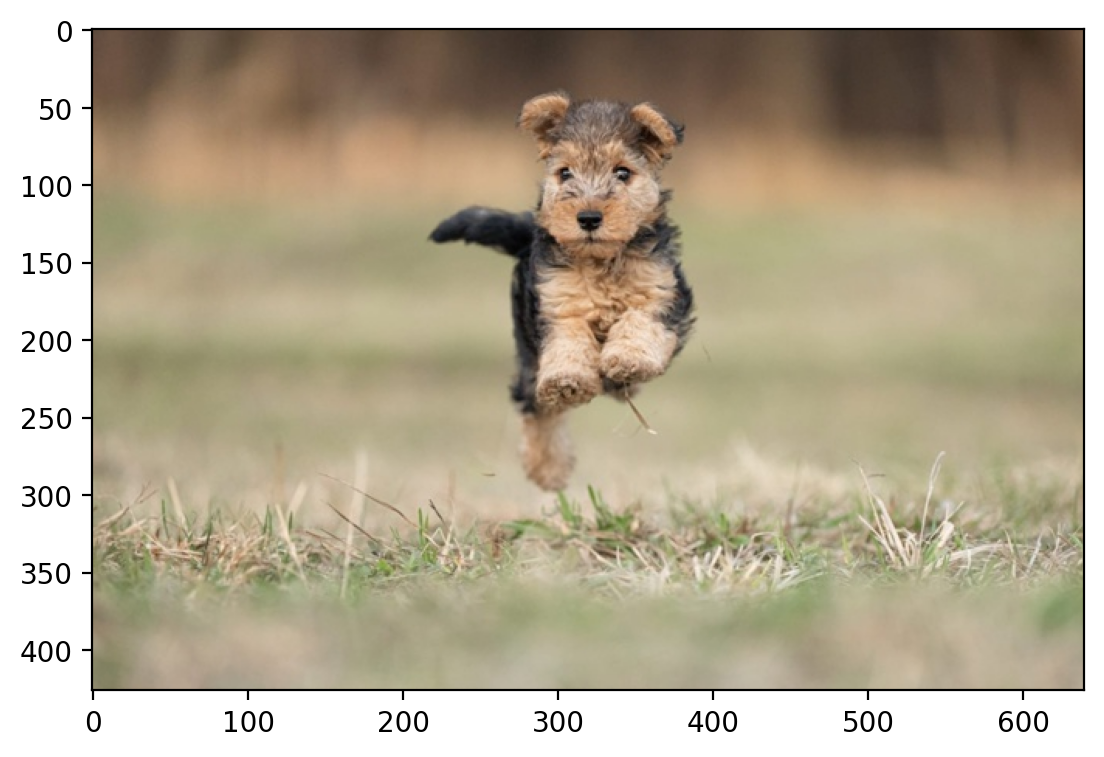

In [4]:
im = PIL.Image.open("картинка.jpg")
fig, ax = plt.subplots()
ax.imshow(im)
plt.show()